# data preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations to be applied to the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and prepare the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 105397557.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainset.targets[0]

6

0 255 (32, 32, 3)


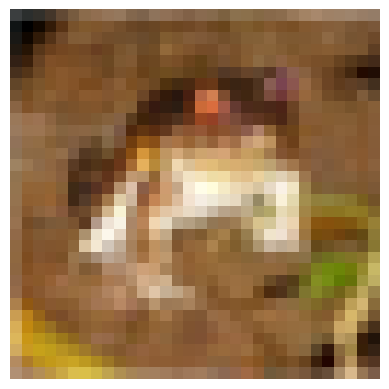

In [ ]:
import matplotlib.pyplot as plt

img = trainset.data[0]

plt.imshow(img)
plt.axis("off")

print(img.min(), img.max(), img.shape)

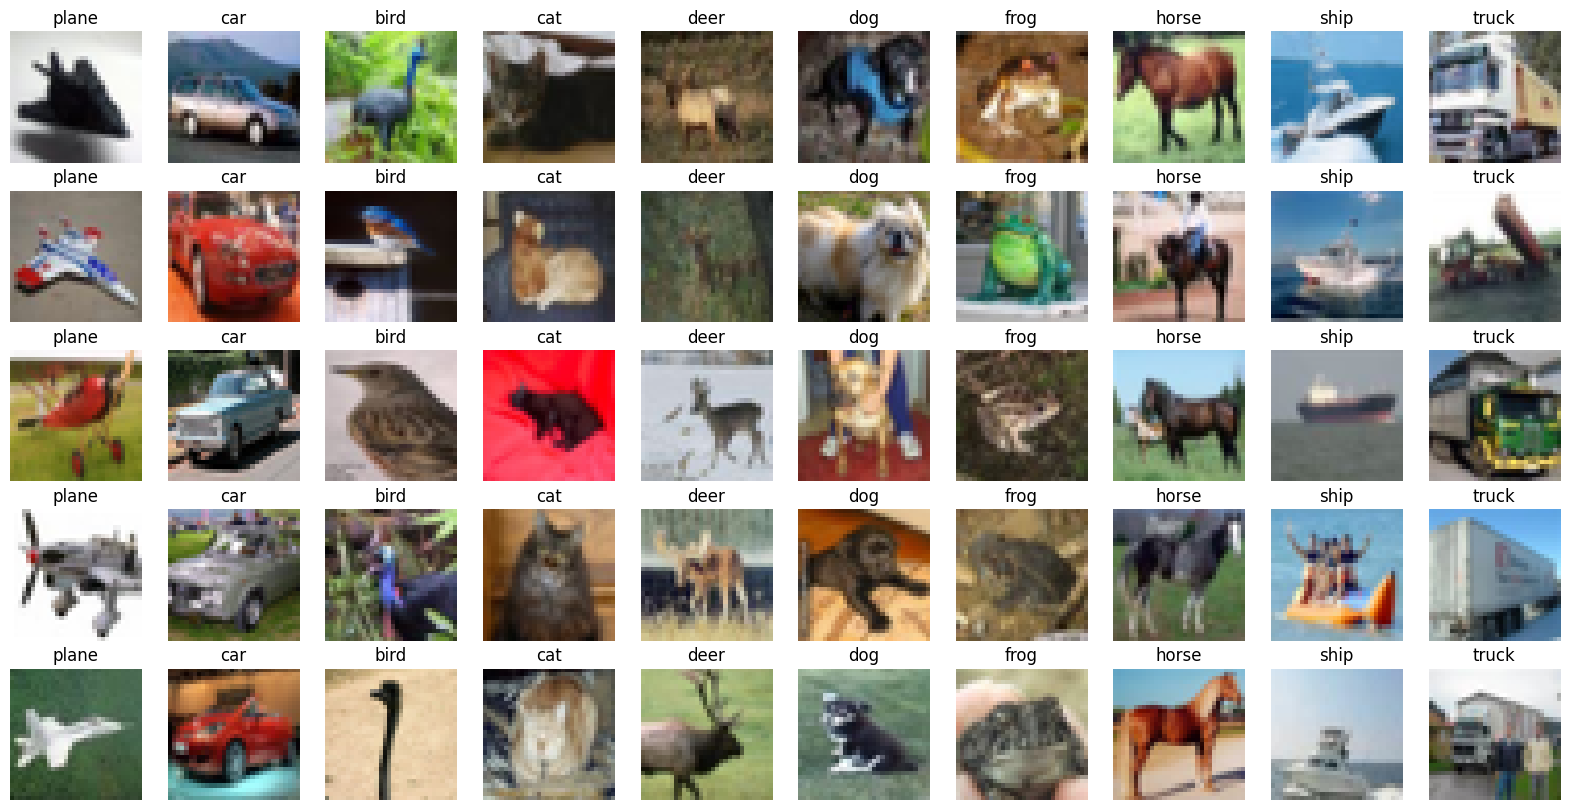

In [ ]:
# Select 5 images from each of the 10 classes
images = []
for i in range(10):
    class_images = []
    index = -1
    for j in range(5):
        while True:
            # index = torch.randint(len(trainset), size=(1,)).item()
            index += 1
            if trainset.targets[index] == i:
                class_images.append(trainset.data[index])
                break
    images.append(class_images)

# Display images in a grid format
fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        axs[i, j].imshow(images[j][i])
        axs[i, j].axis('off')
        axs[i, j].set_title(classes[j])
plt.show()

# baseline

In [3]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


## model

In [4]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [6]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

In [7]:
class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

In [8]:
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [9]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [10]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [11]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [12]:
params = list(model.parameters())

total_params = sum(p.numel() for p in params)

total_params

NameError: ignored

In [13]:
!pip install torch-summary
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

NameError: ignored

## diffusion

In [14]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [15]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [16]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [17]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    # if t in [0, 50, 100, 150, 199]:
    #   pass

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [18]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [19]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("/content/drive/MyDrive/ITC/ATIA/selfcali/results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [20]:
image_size = 32
channels = 3
batch_size = 4
timesteps = 200

In [115]:
# define beta schedule
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

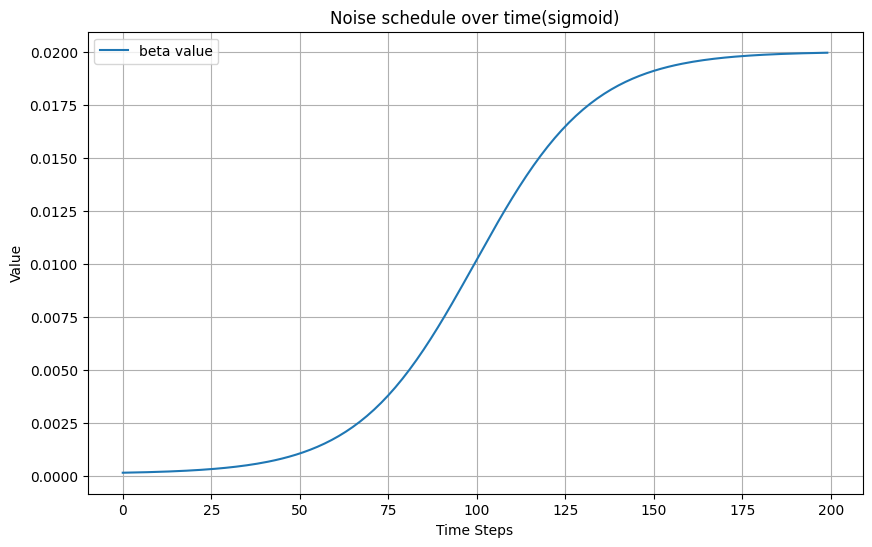

In [113]:
import numpy as np

# 创建时间步
time_steps = np.arange(200)

# 绘制图线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, betas, label='beta value')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Noise schedule over time(sigmoid)')
plt.legend()
plt.grid(True)

# 显示图线
plt.show()

## train

In [22]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
model

Unet(
  (init_conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=128, out_features=20, bias=True)
        )
        (ds_conv): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=20)
        (net): Sequential(
          (0): GroupNorm(1, 20, eps=1e-05, affine=True)
          (1): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d

In [ ]:
from torchvision.utils import save_image

epochs = 5
# model_save_path = '/content/drive/MyDrive/ITC/ATIA/selfcali/'

for epoch in range(epochs):
    for step, batch in enumerate(trainloader):
      optimizer.zero_grad()

      batch_size = batch[1].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Epoch:{}/{}, Step{}/{}, Loss: {:.4f}".format(epoch, 5, step, len(trainloader), loss.item()))

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, image_size=image_size, batch_size=n, channels=channels), batches))
        all_images_list_tensor = [torch.tensor(sample) for sample in all_images_list[0]]
        all_images = torch.cat(all_images_list_tensor, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

    # torch.save(model.state_dict(), model_save_path)

    model_dilename = f'/content/drive/MyDrive/ITC/ATIA/selfcali/model.bin'
    torch.save(model.state_dict(), model_dilename)
    print('model saved')

Epoch:0/5, Step0/12500, Loss: 0.5315
Epoch:0/5, Step100/12500, Loss: 0.3255
Epoch:0/5, Step200/12500, Loss: 0.1662
Epoch:0/5, Step300/12500, Loss: 0.0675
Epoch:0/5, Step400/12500, Loss: 0.0375
Epoch:0/5, Step500/12500, Loss: 0.0270
Epoch:0/5, Step600/12500, Loss: 0.0284
Epoch:0/5, Step700/12500, Loss: 0.0176
Epoch:0/5, Step800/12500, Loss: 0.0459
Epoch:0/5, Step900/12500, Loss: 0.0591
Epoch:0/5, Step1000/12500, Loss: 0.0128


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step1100/12500, Loss: 0.1418
Epoch:0/5, Step1200/12500, Loss: 0.0271
Epoch:0/5, Step1300/12500, Loss: 0.0372
Epoch:0/5, Step1400/12500, Loss: 0.0217
Epoch:0/5, Step1500/12500, Loss: 0.0494
Epoch:0/5, Step1600/12500, Loss: 0.0316
Epoch:0/5, Step1700/12500, Loss: 0.0288
Epoch:0/5, Step1800/12500, Loss: 0.0171
Epoch:0/5, Step1900/12500, Loss: 0.0859
Epoch:0/5, Step2000/12500, Loss: 0.0281


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step2100/12500, Loss: 0.0544
Epoch:0/5, Step2200/12500, Loss: 0.0502
Epoch:0/5, Step2300/12500, Loss: 0.0202
Epoch:0/5, Step2400/12500, Loss: 0.0273
Epoch:0/5, Step2500/12500, Loss: 0.0449
Epoch:0/5, Step2600/12500, Loss: 0.0279
Epoch:0/5, Step2700/12500, Loss: 0.0518
Epoch:0/5, Step2800/12500, Loss: 0.0310
Epoch:0/5, Step2900/12500, Loss: 0.0370
Epoch:0/5, Step3000/12500, Loss: 0.0557


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step3100/12500, Loss: 0.0792
Epoch:0/5, Step3200/12500, Loss: 0.0855
Epoch:0/5, Step3300/12500, Loss: 0.0246
Epoch:0/5, Step3400/12500, Loss: 0.0195
Epoch:0/5, Step3500/12500, Loss: 0.0263
Epoch:0/5, Step3600/12500, Loss: 0.0407
Epoch:0/5, Step3700/12500, Loss: 0.1124
Epoch:0/5, Step3800/12500, Loss: 0.0381
Epoch:0/5, Step3900/12500, Loss: 0.0767
Epoch:0/5, Step4000/12500, Loss: 0.0177


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step4100/12500, Loss: 0.0307
Epoch:0/5, Step4200/12500, Loss: 0.0647
Epoch:0/5, Step4300/12500, Loss: 0.0163
Epoch:0/5, Step4400/12500, Loss: 0.0333
Epoch:0/5, Step4500/12500, Loss: 0.0786
Epoch:0/5, Step4600/12500, Loss: 0.0962
Epoch:0/5, Step4700/12500, Loss: 0.0542
Epoch:0/5, Step4800/12500, Loss: 0.0220
Epoch:0/5, Step4900/12500, Loss: 0.0288
Epoch:0/5, Step5000/12500, Loss: 0.0240


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step5100/12500, Loss: 0.0222
Epoch:0/5, Step5200/12500, Loss: 0.0212
Epoch:0/5, Step5300/12500, Loss: 0.0233
Epoch:0/5, Step5400/12500, Loss: 0.0236
Epoch:0/5, Step5500/12500, Loss: 0.0185
Epoch:0/5, Step5600/12500, Loss: 0.0898
Epoch:0/5, Step5700/12500, Loss: 0.0770
Epoch:0/5, Step5800/12500, Loss: 0.0393
Epoch:0/5, Step5900/12500, Loss: 0.0180
Epoch:0/5, Step6000/12500, Loss: 0.0274


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step6100/12500, Loss: 0.0446
Epoch:0/5, Step6200/12500, Loss: 0.0706
Epoch:0/5, Step6300/12500, Loss: 0.0514
Epoch:0/5, Step6400/12500, Loss: 0.0415
Epoch:0/5, Step6500/12500, Loss: 0.0472
Epoch:0/5, Step6600/12500, Loss: 0.0707
Epoch:0/5, Step6700/12500, Loss: 0.0719
Epoch:0/5, Step6800/12500, Loss: 0.0142
Epoch:0/5, Step6900/12500, Loss: 0.0211
Epoch:0/5, Step7000/12500, Loss: 0.0462


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step7100/12500, Loss: 0.0267
Epoch:0/5, Step7200/12500, Loss: 0.0192
Epoch:0/5, Step7300/12500, Loss: 0.0177
Epoch:0/5, Step7400/12500, Loss: 0.0932
Epoch:0/5, Step7500/12500, Loss: 0.0295
Epoch:0/5, Step7600/12500, Loss: 0.0712
Epoch:0/5, Step7700/12500, Loss: 0.0350
Epoch:0/5, Step7800/12500, Loss: 0.0188
Epoch:0/5, Step7900/12500, Loss: 0.0190
Epoch:0/5, Step8000/12500, Loss: 0.0674


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step8100/12500, Loss: 0.0349
Epoch:0/5, Step8200/12500, Loss: 0.0254
Epoch:0/5, Step8300/12500, Loss: 0.0173
Epoch:0/5, Step8400/12500, Loss: 0.0392
Epoch:0/5, Step8500/12500, Loss: 0.0397
Epoch:0/5, Step8600/12500, Loss: 0.0374
Epoch:0/5, Step8700/12500, Loss: 0.0507
Epoch:0/5, Step8800/12500, Loss: 0.0518
Epoch:0/5, Step8900/12500, Loss: 0.0363
Epoch:0/5, Step9000/12500, Loss: 0.0289


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step9100/12500, Loss: 0.0188
Epoch:0/5, Step9200/12500, Loss: 0.0318
Epoch:0/5, Step9300/12500, Loss: 0.0360
Epoch:0/5, Step9400/12500, Loss: 0.0352
Epoch:0/5, Step9500/12500, Loss: 0.0165
Epoch:0/5, Step9600/12500, Loss: 0.0166
Epoch:0/5, Step9700/12500, Loss: 0.0398
Epoch:0/5, Step9800/12500, Loss: 0.0125
Epoch:0/5, Step9900/12500, Loss: 0.0866
Epoch:0/5, Step10000/12500, Loss: 0.0337


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step10100/12500, Loss: 0.0221
Epoch:0/5, Step10200/12500, Loss: 0.0278
Epoch:0/5, Step10300/12500, Loss: 0.0219
Epoch:0/5, Step10400/12500, Loss: 0.0144
Epoch:0/5, Step10500/12500, Loss: 0.0176
Epoch:0/5, Step10600/12500, Loss: 0.0230
Epoch:0/5, Step10700/12500, Loss: 0.0431
Epoch:0/5, Step10800/12500, Loss: 0.0738
Epoch:0/5, Step10900/12500, Loss: 0.0330
Epoch:0/5, Step11000/12500, Loss: 0.0160


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step11100/12500, Loss: 0.0176
Epoch:0/5, Step11200/12500, Loss: 0.0301
Epoch:0/5, Step11300/12500, Loss: 0.0521
Epoch:0/5, Step11400/12500, Loss: 0.0418
Epoch:0/5, Step11500/12500, Loss: 0.0349
Epoch:0/5, Step11600/12500, Loss: 0.0269
Epoch:0/5, Step11700/12500, Loss: 0.0393
Epoch:0/5, Step11800/12500, Loss: 0.0438
Epoch:0/5, Step11900/12500, Loss: 0.0577
Epoch:0/5, Step12000/12500, Loss: 0.0608


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:0/5, Step12100/12500, Loss: 0.0513
Epoch:0/5, Step12200/12500, Loss: 0.0653
Epoch:0/5, Step12300/12500, Loss: 0.0274
Epoch:0/5, Step12400/12500, Loss: 0.0154
model saved
Epoch:1/5, Step0/12500, Loss: 0.0434
Epoch:1/5, Step100/12500, Loss: 0.0408
Epoch:1/5, Step200/12500, Loss: 0.0410
Epoch:1/5, Step300/12500, Loss: 0.1047
Epoch:1/5, Step400/12500, Loss: 0.0283
Epoch:1/5, Step500/12500, Loss: 0.0329
Epoch:1/5, Step600/12500, Loss: 0.0601
Epoch:1/5, Step700/12500, Loss: 0.0150
Epoch:1/5, Step800/12500, Loss: 0.0276
Epoch:1/5, Step900/12500, Loss: 0.0254
Epoch:1/5, Step1000/12500, Loss: 0.0145


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step1100/12500, Loss: 0.0377
Epoch:1/5, Step1200/12500, Loss: 0.0157
Epoch:1/5, Step1300/12500, Loss: 0.0635
Epoch:1/5, Step1400/12500, Loss: 0.0279
Epoch:1/5, Step1500/12500, Loss: 0.0838
Epoch:1/5, Step1600/12500, Loss: 0.0858
Epoch:1/5, Step1700/12500, Loss: 0.0263
Epoch:1/5, Step1800/12500, Loss: 0.0174
Epoch:1/5, Step1900/12500, Loss: 0.0274
Epoch:1/5, Step2000/12500, Loss: 0.0411


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step2100/12500, Loss: 0.0334
Epoch:1/5, Step2200/12500, Loss: 0.0160
Epoch:1/5, Step2300/12500, Loss: 0.0339
Epoch:1/5, Step2400/12500, Loss: 0.0378
Epoch:1/5, Step2500/12500, Loss: 0.0149
Epoch:1/5, Step2600/12500, Loss: 0.0192
Epoch:1/5, Step2700/12500, Loss: 0.0248
Epoch:1/5, Step2800/12500, Loss: 0.0477
Epoch:1/5, Step2900/12500, Loss: 0.0335
Epoch:1/5, Step3000/12500, Loss: 0.0738


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step3100/12500, Loss: 0.0316
Epoch:1/5, Step3200/12500, Loss: 0.0128
Epoch:1/5, Step3300/12500, Loss: 0.0318
Epoch:1/5, Step3400/12500, Loss: 0.0332
Epoch:1/5, Step3500/12500, Loss: 0.1031
Epoch:1/5, Step3600/12500, Loss: 0.0258
Epoch:1/5, Step3700/12500, Loss: 0.0161
Epoch:1/5, Step3800/12500, Loss: 0.0209
Epoch:1/5, Step3900/12500, Loss: 0.0531
Epoch:1/5, Step4000/12500, Loss: 0.0176


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step4100/12500, Loss: 0.0332
Epoch:1/5, Step4200/12500, Loss: 0.0894
Epoch:1/5, Step4300/12500, Loss: 0.0543
Epoch:1/5, Step4400/12500, Loss: 0.0614
Epoch:1/5, Step4500/12500, Loss: 0.0633
Epoch:1/5, Step4600/12500, Loss: 0.0485
Epoch:1/5, Step4700/12500, Loss: 0.0269
Epoch:1/5, Step4800/12500, Loss: 0.0629
Epoch:1/5, Step4900/12500, Loss: 0.0138
Epoch:1/5, Step5000/12500, Loss: 0.0351


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step5100/12500, Loss: 0.0302
Epoch:1/5, Step5200/12500, Loss: 0.0343
Epoch:1/5, Step5300/12500, Loss: 0.0323
Epoch:1/5, Step5400/12500, Loss: 0.0610
Epoch:1/5, Step5500/12500, Loss: 0.0427
Epoch:1/5, Step5600/12500, Loss: 0.0266
Epoch:1/5, Step5700/12500, Loss: 0.0280
Epoch:1/5, Step5800/12500, Loss: 0.0222
Epoch:1/5, Step5900/12500, Loss: 0.0184
Epoch:1/5, Step6000/12500, Loss: 0.0197


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step6100/12500, Loss: 0.1002
Epoch:1/5, Step6200/12500, Loss: 0.0259
Epoch:1/5, Step6300/12500, Loss: 0.0554
Epoch:1/5, Step6400/12500, Loss: 0.0127
Epoch:1/5, Step6500/12500, Loss: 0.0361
Epoch:1/5, Step6600/12500, Loss: 0.0285
Epoch:1/5, Step6700/12500, Loss: 0.0552
Epoch:1/5, Step6800/12500, Loss: 0.0777
Epoch:1/5, Step6900/12500, Loss: 0.0182
Epoch:1/5, Step7000/12500, Loss: 0.1039


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step7100/12500, Loss: 0.0299
Epoch:1/5, Step7200/12500, Loss: 0.0270
Epoch:1/5, Step7300/12500, Loss: 0.0291
Epoch:1/5, Step7400/12500, Loss: 0.0149
Epoch:1/5, Step7500/12500, Loss: 0.0466
Epoch:1/5, Step7600/12500, Loss: 0.0106
Epoch:1/5, Step7700/12500, Loss: 0.0762
Epoch:1/5, Step7800/12500, Loss: 0.0638
Epoch:1/5, Step7900/12500, Loss: 0.0164
Epoch:1/5, Step8000/12500, Loss: 0.0372


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step8100/12500, Loss: 0.1112
Epoch:1/5, Step8200/12500, Loss: 0.0372
Epoch:1/5, Step8300/12500, Loss: 0.0413
Epoch:1/5, Step8400/12500, Loss: 0.0594
Epoch:1/5, Step8500/12500, Loss: 0.0686
Epoch:1/5, Step8600/12500, Loss: 0.0204
Epoch:1/5, Step8700/12500, Loss: 0.0548
Epoch:1/5, Step8800/12500, Loss: 0.0324
Epoch:1/5, Step8900/12500, Loss: 0.0149
Epoch:1/5, Step9000/12500, Loss: 0.0582


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step9100/12500, Loss: 0.0155
Epoch:1/5, Step9200/12500, Loss: 0.0839
Epoch:1/5, Step9300/12500, Loss: 0.0363
Epoch:1/5, Step9400/12500, Loss: 0.0184
Epoch:1/5, Step9500/12500, Loss: 0.0299
Epoch:1/5, Step9600/12500, Loss: 0.0225
Epoch:1/5, Step9700/12500, Loss: 0.0474
Epoch:1/5, Step9800/12500, Loss: 0.0334
Epoch:1/5, Step9900/12500, Loss: 0.0113
Epoch:1/5, Step10000/12500, Loss: 0.0686


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step10100/12500, Loss: 0.0082
Epoch:1/5, Step10200/12500, Loss: 0.0297
Epoch:1/5, Step10300/12500, Loss: 0.0231
Epoch:1/5, Step10400/12500, Loss: 0.0379
Epoch:1/5, Step10500/12500, Loss: 0.0274
Epoch:1/5, Step10600/12500, Loss: 0.0113
Epoch:1/5, Step10700/12500, Loss: 0.0509
Epoch:1/5, Step10800/12500, Loss: 0.0394
Epoch:1/5, Step10900/12500, Loss: 0.0321
Epoch:1/5, Step11000/12500, Loss: 0.0545


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step11100/12500, Loss: 0.0279
Epoch:1/5, Step11200/12500, Loss: 0.0769
Epoch:1/5, Step11300/12500, Loss: 0.0326
Epoch:1/5, Step11400/12500, Loss: 0.0181
Epoch:1/5, Step11500/12500, Loss: 0.0386
Epoch:1/5, Step11600/12500, Loss: 0.0231
Epoch:1/5, Step11700/12500, Loss: 0.0196
Epoch:1/5, Step11800/12500, Loss: 0.0576
Epoch:1/5, Step11900/12500, Loss: 0.0426
Epoch:1/5, Step12000/12500, Loss: 0.0125


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:1/5, Step12100/12500, Loss: 0.0265
Epoch:1/5, Step12200/12500, Loss: 0.0230
Epoch:1/5, Step12300/12500, Loss: 0.0267
Epoch:1/5, Step12400/12500, Loss: 0.0790
model saved
Epoch:2/5, Step0/12500, Loss: 0.0607
Epoch:2/5, Step100/12500, Loss: 0.0271
Epoch:2/5, Step200/12500, Loss: 0.0111
Epoch:2/5, Step300/12500, Loss: 0.0438
Epoch:2/5, Step400/12500, Loss: 0.0342
Epoch:2/5, Step500/12500, Loss: 0.0200
Epoch:2/5, Step600/12500, Loss: 0.0215
Epoch:2/5, Step700/12500, Loss: 0.0602
Epoch:2/5, Step800/12500, Loss: 0.0229
Epoch:2/5, Step900/12500, Loss: 0.0126
Epoch:2/5, Step1000/12500, Loss: 0.0216


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step1100/12500, Loss: 0.0375
Epoch:2/5, Step1200/12500, Loss: 0.0205
Epoch:2/5, Step1300/12500, Loss: 0.0314
Epoch:2/5, Step1400/12500, Loss: 0.0342
Epoch:2/5, Step1500/12500, Loss: 0.0170
Epoch:2/5, Step1600/12500, Loss: 0.0268
Epoch:2/5, Step1700/12500, Loss: 0.0288
Epoch:2/5, Step1800/12500, Loss: 0.0693
Epoch:2/5, Step1900/12500, Loss: 0.0134
Epoch:2/5, Step2000/12500, Loss: 0.0272


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step2100/12500, Loss: 0.0283
Epoch:2/5, Step2200/12500, Loss: 0.0185
Epoch:2/5, Step2300/12500, Loss: 0.0364
Epoch:2/5, Step2400/12500, Loss: 0.1127
Epoch:2/5, Step2500/12500, Loss: 0.0433
Epoch:2/5, Step2600/12500, Loss: 0.0205
Epoch:2/5, Step2700/12500, Loss: 0.0264
Epoch:2/5, Step2800/12500, Loss: 0.0348
Epoch:2/5, Step2900/12500, Loss: 0.0913
Epoch:2/5, Step3000/12500, Loss: 0.0633


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step3100/12500, Loss: 0.0394
Epoch:2/5, Step3200/12500, Loss: 0.0141
Epoch:2/5, Step3300/12500, Loss: 0.0467
Epoch:2/5, Step3400/12500, Loss: 0.0133
Epoch:2/5, Step3500/12500, Loss: 0.0244
Epoch:2/5, Step3600/12500, Loss: 0.0467
Epoch:2/5, Step3700/12500, Loss: 0.0441
Epoch:2/5, Step3800/12500, Loss: 0.0337
Epoch:2/5, Step3900/12500, Loss: 0.0247
Epoch:2/5, Step4000/12500, Loss: 0.0266


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step4100/12500, Loss: 0.0258
Epoch:2/5, Step4200/12500, Loss: 0.0324
Epoch:2/5, Step4300/12500, Loss: 0.0335
Epoch:2/5, Step4400/12500, Loss: 0.0886
Epoch:2/5, Step4500/12500, Loss: 0.0194
Epoch:2/5, Step4600/12500, Loss: 0.0256
Epoch:2/5, Step4700/12500, Loss: 0.0238
Epoch:2/5, Step4800/12500, Loss: 0.0780
Epoch:2/5, Step4900/12500, Loss: 0.0778
Epoch:2/5, Step5000/12500, Loss: 0.0203


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step5100/12500, Loss: 0.0285
Epoch:2/5, Step5200/12500, Loss: 0.0358
Epoch:2/5, Step5300/12500, Loss: 0.0295
Epoch:2/5, Step5400/12500, Loss: 0.0207
Epoch:2/5, Step5500/12500, Loss: 0.0222
Epoch:2/5, Step5600/12500, Loss: 0.0722
Epoch:2/5, Step5700/12500, Loss: 0.0186
Epoch:2/5, Step5800/12500, Loss: 0.0288
Epoch:2/5, Step5900/12500, Loss: 0.0525
Epoch:2/5, Step6000/12500, Loss: 0.0275


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step6100/12500, Loss: 0.0481
Epoch:2/5, Step6200/12500, Loss: 0.0543
Epoch:2/5, Step6300/12500, Loss: 0.0319
Epoch:2/5, Step6400/12500, Loss: 0.0148
Epoch:2/5, Step6500/12500, Loss: 0.0440
Epoch:2/5, Step6600/12500, Loss: 0.0189
Epoch:2/5, Step6700/12500, Loss: 0.0213
Epoch:2/5, Step6800/12500, Loss: 0.0635
Epoch:2/5, Step6900/12500, Loss: 0.0337
Epoch:2/5, Step7000/12500, Loss: 0.1143


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step7100/12500, Loss: 0.0404
Epoch:2/5, Step7200/12500, Loss: 0.0196
Epoch:2/5, Step7300/12500, Loss: 0.0327
Epoch:2/5, Step7400/12500, Loss: 0.0345
Epoch:2/5, Step7500/12500, Loss: 0.0720
Epoch:2/5, Step7600/12500, Loss: 0.0248
Epoch:2/5, Step7700/12500, Loss: 0.0450
Epoch:2/5, Step7800/12500, Loss: 0.0565
Epoch:2/5, Step7900/12500, Loss: 0.0634
Epoch:2/5, Step8000/12500, Loss: 0.1239


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step8100/12500, Loss: 0.0186
Epoch:2/5, Step8200/12500, Loss: 0.0566
Epoch:2/5, Step8300/12500, Loss: 0.0344
Epoch:2/5, Step8400/12500, Loss: 0.0616
Epoch:2/5, Step8500/12500, Loss: 0.0317
Epoch:2/5, Step8600/12500, Loss: 0.0792
Epoch:2/5, Step8700/12500, Loss: 0.0380
Epoch:2/5, Step8800/12500, Loss: 0.0216
Epoch:2/5, Step8900/12500, Loss: 0.0154
Epoch:2/5, Step9000/12500, Loss: 0.0905


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step9100/12500, Loss: 0.0330
Epoch:2/5, Step9200/12500, Loss: 0.0337
Epoch:2/5, Step9300/12500, Loss: 0.0634
Epoch:2/5, Step9400/12500, Loss: 0.0498
Epoch:2/5, Step9500/12500, Loss: 0.0182
Epoch:2/5, Step9600/12500, Loss: 0.0176
Epoch:2/5, Step9700/12500, Loss: 0.0188
Epoch:2/5, Step9800/12500, Loss: 0.0199
Epoch:2/5, Step9900/12500, Loss: 0.0871
Epoch:2/5, Step10000/12500, Loss: 0.0147


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step10100/12500, Loss: 0.1343
Epoch:2/5, Step10200/12500, Loss: 0.0327
Epoch:2/5, Step10300/12500, Loss: 0.0426
Epoch:2/5, Step10400/12500, Loss: 0.0141
Epoch:2/5, Step10500/12500, Loss: 0.0246
Epoch:2/5, Step10600/12500, Loss: 0.0175
Epoch:2/5, Step10700/12500, Loss: 0.0293
Epoch:2/5, Step10800/12500, Loss: 0.0156
Epoch:2/5, Step10900/12500, Loss: 0.0193
Epoch:2/5, Step11000/12500, Loss: 0.0285


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step11100/12500, Loss: 0.0134
Epoch:2/5, Step11200/12500, Loss: 0.0156
Epoch:2/5, Step11300/12500, Loss: 0.0303
Epoch:2/5, Step11400/12500, Loss: 0.0852
Epoch:2/5, Step11500/12500, Loss: 0.0158
Epoch:2/5, Step11600/12500, Loss: 0.1154
Epoch:2/5, Step11700/12500, Loss: 0.0424
Epoch:2/5, Step11800/12500, Loss: 0.0284
Epoch:2/5, Step11900/12500, Loss: 0.0133
Epoch:2/5, Step12000/12500, Loss: 0.0272


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:2/5, Step12100/12500, Loss: 0.0145
Epoch:2/5, Step12200/12500, Loss: 0.0206
Epoch:2/5, Step12300/12500, Loss: 0.0140
Epoch:2/5, Step12400/12500, Loss: 0.0149
model saved
Epoch:3/5, Step0/12500, Loss: 0.0190
Epoch:3/5, Step100/12500, Loss: 0.0326
Epoch:3/5, Step200/12500, Loss: 0.0321
Epoch:3/5, Step300/12500, Loss: 0.0507
Epoch:3/5, Step400/12500, Loss: 0.0782
Epoch:3/5, Step500/12500, Loss: 0.0157
Epoch:3/5, Step600/12500, Loss: 0.0209
Epoch:3/5, Step700/12500, Loss: 0.0532
Epoch:3/5, Step800/12500, Loss: 0.0192
Epoch:3/5, Step900/12500, Loss: 0.0152
Epoch:3/5, Step1000/12500, Loss: 0.0319


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step1100/12500, Loss: 0.0202
Epoch:3/5, Step1200/12500, Loss: 0.0219
Epoch:3/5, Step1300/12500, Loss: 0.1201
Epoch:3/5, Step1400/12500, Loss: 0.0813
Epoch:3/5, Step1500/12500, Loss: 0.0574
Epoch:3/5, Step1600/12500, Loss: 0.0422
Epoch:3/5, Step1700/12500, Loss: 0.0563
Epoch:3/5, Step1800/12500, Loss: 0.0304
Epoch:3/5, Step1900/12500, Loss: 0.0248
Epoch:3/5, Step2000/12500, Loss: 0.0366


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step2100/12500, Loss: 0.0229
Epoch:3/5, Step2200/12500, Loss: 0.1013
Epoch:3/5, Step2300/12500, Loss: 0.0242
Epoch:3/5, Step2400/12500, Loss: 0.0295
Epoch:3/5, Step2500/12500, Loss: 0.0726
Epoch:3/5, Step2600/12500, Loss: 0.0196
Epoch:3/5, Step2700/12500, Loss: 0.0422
Epoch:3/5, Step2800/12500, Loss: 0.0119
Epoch:3/5, Step2900/12500, Loss: 0.0583
Epoch:3/5, Step3000/12500, Loss: 0.0807


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step3100/12500, Loss: 0.0400
Epoch:3/5, Step3200/12500, Loss: 0.0521
Epoch:3/5, Step3300/12500, Loss: 0.1008
Epoch:3/5, Step3400/12500, Loss: 0.0272
Epoch:3/5, Step3500/12500, Loss: 0.0295
Epoch:3/5, Step3600/12500, Loss: 0.0425
Epoch:3/5, Step3700/12500, Loss: 0.0364
Epoch:3/5, Step3800/12500, Loss: 0.0619
Epoch:3/5, Step3900/12500, Loss: 0.0379
Epoch:3/5, Step4000/12500, Loss: 0.0145


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step4100/12500, Loss: 0.0378
Epoch:3/5, Step4200/12500, Loss: 0.0148
Epoch:3/5, Step4300/12500, Loss: 0.0222
Epoch:3/5, Step4400/12500, Loss: 0.0597
Epoch:3/5, Step4500/12500, Loss: 0.0472
Epoch:3/5, Step4600/12500, Loss: 0.0201
Epoch:3/5, Step4700/12500, Loss: 0.0607
Epoch:3/5, Step4800/12500, Loss: 0.1118
Epoch:3/5, Step4900/12500, Loss: 0.0229
Epoch:3/5, Step5000/12500, Loss: 0.0225


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step5100/12500, Loss: 0.0945
Epoch:3/5, Step5200/12500, Loss: 0.0952
Epoch:3/5, Step5300/12500, Loss: 0.1923
Epoch:3/5, Step5400/12500, Loss: 0.0096
Epoch:3/5, Step5500/12500, Loss: 0.0426
Epoch:3/5, Step5600/12500, Loss: 0.0448
Epoch:3/5, Step5700/12500, Loss: 0.0181
Epoch:3/5, Step5800/12500, Loss: 0.0390
Epoch:3/5, Step5900/12500, Loss: 0.0245
Epoch:3/5, Step6000/12500, Loss: 0.0285


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step6100/12500, Loss: 0.0101
Epoch:3/5, Step6200/12500, Loss: 0.0124
Epoch:3/5, Step6300/12500, Loss: 0.0133
Epoch:3/5, Step6400/12500, Loss: 0.0195
Epoch:3/5, Step6500/12500, Loss: 0.0395
Epoch:3/5, Step6600/12500, Loss: 0.0374
Epoch:3/5, Step6700/12500, Loss: 0.0287
Epoch:3/5, Step6800/12500, Loss: 0.0240
Epoch:3/5, Step6900/12500, Loss: 0.0072
Epoch:3/5, Step7000/12500, Loss: 0.0197


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step7100/12500, Loss: 0.0118
Epoch:3/5, Step7200/12500, Loss: 0.0153
Epoch:3/5, Step7300/12500, Loss: 0.0925
Epoch:3/5, Step7400/12500, Loss: 0.0531
Epoch:3/5, Step7500/12500, Loss: 0.0222
Epoch:3/5, Step7600/12500, Loss: 0.0240
Epoch:3/5, Step7700/12500, Loss: 0.0459
Epoch:3/5, Step7800/12500, Loss: 0.0646
Epoch:3/5, Step7900/12500, Loss: 0.0419
Epoch:3/5, Step8000/12500, Loss: 0.0749


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step8100/12500, Loss: 0.0423
Epoch:3/5, Step8200/12500, Loss: 0.0400
Epoch:3/5, Step8300/12500, Loss: 0.0251
Epoch:3/5, Step8400/12500, Loss: 0.0296
Epoch:3/5, Step8500/12500, Loss: 0.0923
Epoch:3/5, Step8600/12500, Loss: 0.0206
Epoch:3/5, Step8700/12500, Loss: 0.0410
Epoch:3/5, Step8800/12500, Loss: 0.0272
Epoch:3/5, Step8900/12500, Loss: 0.0665
Epoch:3/5, Step9000/12500, Loss: 0.0780


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step9100/12500, Loss: 0.0119
Epoch:3/5, Step9200/12500, Loss: 0.0265
Epoch:3/5, Step9300/12500, Loss: 0.0293
Epoch:3/5, Step9400/12500, Loss: 0.0508
Epoch:3/5, Step9500/12500, Loss: 0.0359
Epoch:3/5, Step9600/12500, Loss: 0.0193
Epoch:3/5, Step9700/12500, Loss: 0.0161
Epoch:3/5, Step9800/12500, Loss: 0.0198
Epoch:3/5, Step9900/12500, Loss: 0.0331
Epoch:3/5, Step10000/12500, Loss: 0.0508


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step10100/12500, Loss: 0.0385
Epoch:3/5, Step10200/12500, Loss: 0.0118
Epoch:3/5, Step10300/12500, Loss: 0.0287
Epoch:3/5, Step10400/12500, Loss: 0.0263
Epoch:3/5, Step10500/12500, Loss: 0.0194
Epoch:3/5, Step10600/12500, Loss: 0.1256
Epoch:3/5, Step10700/12500, Loss: 0.0364
Epoch:3/5, Step10800/12500, Loss: 0.0253
Epoch:3/5, Step10900/12500, Loss: 0.0228
Epoch:3/5, Step11000/12500, Loss: 0.0328


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step11100/12500, Loss: 0.0240
Epoch:3/5, Step11200/12500, Loss: 0.0263
Epoch:3/5, Step11300/12500, Loss: 0.1004
Epoch:3/5, Step11400/12500, Loss: 0.0161
Epoch:3/5, Step11500/12500, Loss: 0.0312
Epoch:3/5, Step11600/12500, Loss: 0.0136
Epoch:3/5, Step11700/12500, Loss: 0.0119
Epoch:3/5, Step11800/12500, Loss: 0.0413
Epoch:3/5, Step11900/12500, Loss: 0.0278
Epoch:3/5, Step12000/12500, Loss: 0.0691


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:3/5, Step12100/12500, Loss: 0.0204
Epoch:3/5, Step12200/12500, Loss: 0.0267
Epoch:3/5, Step12300/12500, Loss: 0.0235
Epoch:3/5, Step12400/12500, Loss: 0.0118
model saved
Epoch:4/5, Step0/12500, Loss: 0.0913
Epoch:4/5, Step100/12500, Loss: 0.0648
Epoch:4/5, Step200/12500, Loss: 0.0487
Epoch:4/5, Step300/12500, Loss: 0.0899
Epoch:4/5, Step400/12500, Loss: 0.0264
Epoch:4/5, Step500/12500, Loss: 0.0192
Epoch:4/5, Step600/12500, Loss: 0.0224
Epoch:4/5, Step700/12500, Loss: 0.0135
Epoch:4/5, Step800/12500, Loss: 0.0135
Epoch:4/5, Step900/12500, Loss: 0.0460
Epoch:4/5, Step1000/12500, Loss: 0.0209


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step1100/12500, Loss: 0.0215
Epoch:4/5, Step1200/12500, Loss: 0.0633
Epoch:4/5, Step1300/12500, Loss: 0.0991
Epoch:4/5, Step1400/12500, Loss: 0.0378
Epoch:4/5, Step1500/12500, Loss: 0.0359
Epoch:4/5, Step1600/12500, Loss: 0.0077
Epoch:4/5, Step1700/12500, Loss: 0.0146
Epoch:4/5, Step1800/12500, Loss: 0.0087
Epoch:4/5, Step1900/12500, Loss: 0.0199
Epoch:4/5, Step2000/12500, Loss: 0.0301


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step2100/12500, Loss: 0.0129
Epoch:4/5, Step2200/12500, Loss: 0.0885
Epoch:4/5, Step2300/12500, Loss: 0.0363
Epoch:4/5, Step2400/12500, Loss: 0.0212
Epoch:4/5, Step2500/12500, Loss: 0.0179
Epoch:4/5, Step2600/12500, Loss: 0.0328
Epoch:4/5, Step2700/12500, Loss: 0.0214
Epoch:4/5, Step2800/12500, Loss: 0.0128
Epoch:4/5, Step2900/12500, Loss: 0.0244
Epoch:4/5, Step3000/12500, Loss: 0.0928


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step3100/12500, Loss: 0.0187
Epoch:4/5, Step3200/12500, Loss: 0.0979
Epoch:4/5, Step3300/12500, Loss: 0.0398
Epoch:4/5, Step3400/12500, Loss: 0.0827
Epoch:4/5, Step3500/12500, Loss: 0.0568
Epoch:4/5, Step3600/12500, Loss: 0.0601
Epoch:4/5, Step3700/12500, Loss: 0.0223
Epoch:4/5, Step3800/12500, Loss: 0.0116
Epoch:4/5, Step3900/12500, Loss: 0.0271
Epoch:4/5, Step4000/12500, Loss: 0.0481


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step4100/12500, Loss: 0.0499
Epoch:4/5, Step4200/12500, Loss: 0.0388
Epoch:4/5, Step4300/12500, Loss: 0.0420
Epoch:4/5, Step4400/12500, Loss: 0.0091
Epoch:4/5, Step4500/12500, Loss: 0.0580
Epoch:4/5, Step4600/12500, Loss: 0.0256
Epoch:4/5, Step4700/12500, Loss: 0.0314
Epoch:4/5, Step4800/12500, Loss: 0.0410
Epoch:4/5, Step4900/12500, Loss: 0.0245
Epoch:4/5, Step5000/12500, Loss: 0.0185


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step5100/12500, Loss: 0.0460
Epoch:4/5, Step5200/12500, Loss: 0.0324
Epoch:4/5, Step5300/12500, Loss: 0.0195
Epoch:4/5, Step5400/12500, Loss: 0.0421
Epoch:4/5, Step5500/12500, Loss: 0.0278
Epoch:4/5, Step5600/12500, Loss: 0.0513
Epoch:4/5, Step5700/12500, Loss: 0.0123
Epoch:4/5, Step5800/12500, Loss: 0.0223
Epoch:4/5, Step5900/12500, Loss: 0.0842
Epoch:4/5, Step6000/12500, Loss: 0.0512


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step6100/12500, Loss: 0.0233
Epoch:4/5, Step6200/12500, Loss: 0.0360
Epoch:4/5, Step6300/12500, Loss: 0.0251
Epoch:4/5, Step6400/12500, Loss: 0.0224
Epoch:4/5, Step6500/12500, Loss: 0.0502
Epoch:4/5, Step6600/12500, Loss: 0.0208
Epoch:4/5, Step6700/12500, Loss: 0.0201
Epoch:4/5, Step6800/12500, Loss: 0.0351
Epoch:4/5, Step6900/12500, Loss: 0.0120
Epoch:4/5, Step7000/12500, Loss: 0.0787


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step7100/12500, Loss: 0.0211
Epoch:4/5, Step7200/12500, Loss: 0.0404
Epoch:4/5, Step7300/12500, Loss: 0.0422
Epoch:4/5, Step7400/12500, Loss: 0.0331
Epoch:4/5, Step7500/12500, Loss: 0.0371
Epoch:4/5, Step7600/12500, Loss: 0.0501
Epoch:4/5, Step7700/12500, Loss: 0.0174
Epoch:4/5, Step7800/12500, Loss: 0.0460
Epoch:4/5, Step7900/12500, Loss: 0.0193
Epoch:4/5, Step8000/12500, Loss: 0.0284


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step8100/12500, Loss: 0.0537
Epoch:4/5, Step8200/12500, Loss: 0.0505
Epoch:4/5, Step8300/12500, Loss: 0.0274
Epoch:4/5, Step8400/12500, Loss: 0.0341
Epoch:4/5, Step8500/12500, Loss: 0.0409
Epoch:4/5, Step8600/12500, Loss: 0.0349
Epoch:4/5, Step8700/12500, Loss: 0.0363
Epoch:4/5, Step8800/12500, Loss: 0.0248
Epoch:4/5, Step8900/12500, Loss: 0.0942
Epoch:4/5, Step9000/12500, Loss: 0.0234


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step9100/12500, Loss: 0.0508
Epoch:4/5, Step9200/12500, Loss: 0.0374
Epoch:4/5, Step9300/12500, Loss: 0.0415
Epoch:4/5, Step9400/12500, Loss: 0.0549
Epoch:4/5, Step9500/12500, Loss: 0.0605
Epoch:4/5, Step9600/12500, Loss: 0.0262
Epoch:4/5, Step9700/12500, Loss: 0.0249
Epoch:4/5, Step9800/12500, Loss: 0.0970
Epoch:4/5, Step9900/12500, Loss: 0.0203
Epoch:4/5, Step10000/12500, Loss: 0.0454


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step10100/12500, Loss: 0.0647
Epoch:4/5, Step10200/12500, Loss: 0.0181
Epoch:4/5, Step10300/12500, Loss: 0.0134
Epoch:4/5, Step10400/12500, Loss: 0.0124
Epoch:4/5, Step10500/12500, Loss: 0.0404
Epoch:4/5, Step10600/12500, Loss: 0.0201
Epoch:4/5, Step10700/12500, Loss: 0.0612
Epoch:4/5, Step10800/12500, Loss: 0.0250
Epoch:4/5, Step10900/12500, Loss: 0.0151
Epoch:4/5, Step11000/12500, Loss: 0.0493


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step11100/12500, Loss: 0.0497
Epoch:4/5, Step11200/12500, Loss: 0.0298
Epoch:4/5, Step11300/12500, Loss: 0.0144
Epoch:4/5, Step11400/12500, Loss: 0.0260
Epoch:4/5, Step11500/12500, Loss: 0.0254
Epoch:4/5, Step11600/12500, Loss: 0.0528
Epoch:4/5, Step11700/12500, Loss: 0.0143
Epoch:4/5, Step11800/12500, Loss: 0.0507
Epoch:4/5, Step11900/12500, Loss: 0.0645
Epoch:4/5, Step12000/12500, Loss: 0.0593


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:4/5, Step12100/12500, Loss: 0.0288
Epoch:4/5, Step12200/12500, Loss: 0.0181
Epoch:4/5, Step12300/12500, Loss: 0.0348
Epoch:4/5, Step12400/12500, Loss: 0.0307
model saved


In [23]:
# if you are not going to train your model

model_dilename = f'/content/drive/MyDrive/ITC/ATIA/selfcali/model.bin'

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)

model.load_state_dict(torch.load(model_dilename, map_location=torch.device('cpu')))

model.eval()

Unet(
  (init_conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=128, out_features=20, bias=True)
        )
        (ds_conv): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=20)
        (net): Sequential(
          (0): GroupNorm(1, 20, eps=1e-05, affine=True)
          (1): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d

In [93]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=32, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [88]:
import numpy as np


# 定义映射范围
min_value = -1.047121
max_value = 0.83954674
new_min = 0
new_max = 255

# 使用映射公式进行映射
mapped_array = (samples[-1][0] - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
mapped_array = np.round(mapped_array).astype(int)
mapped_array = np.transpose(mapped_array, (1, 2, 0))

(-0.5, 31.5, 31.5, -0.5)

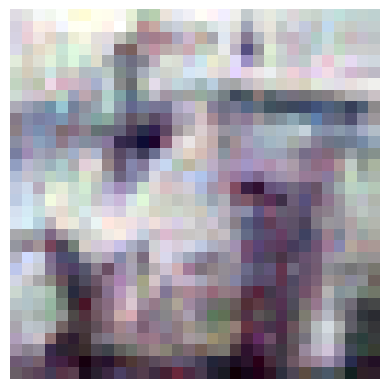

In [89]:
# show a random one
plt.imshow(mapped_array)
plt.axis("off")

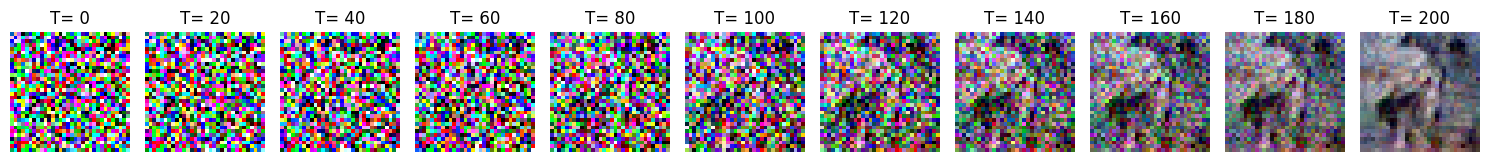

In [98]:
# 创建一个 1x10 的图片布局
fig, axes = plt.subplots(1, 11, figsize=(15, 2))  # 1 row, 10 columns
image_list = [samples[t][0] for t in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 199]]

# 循环在每个子图上绘制内容
for i, ax in enumerate(axes):
    image = (image_list[i] - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
    image = np.round(image).astype(int)
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)  # cmap='gray' 表示以灰度模式显示图像
    if i<199:
      ax.set_title(f'T= {i * 20}')
    else:
      ax.set_title(f'T= 199')
    ax.axis('off')  # 关闭坐标轴

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

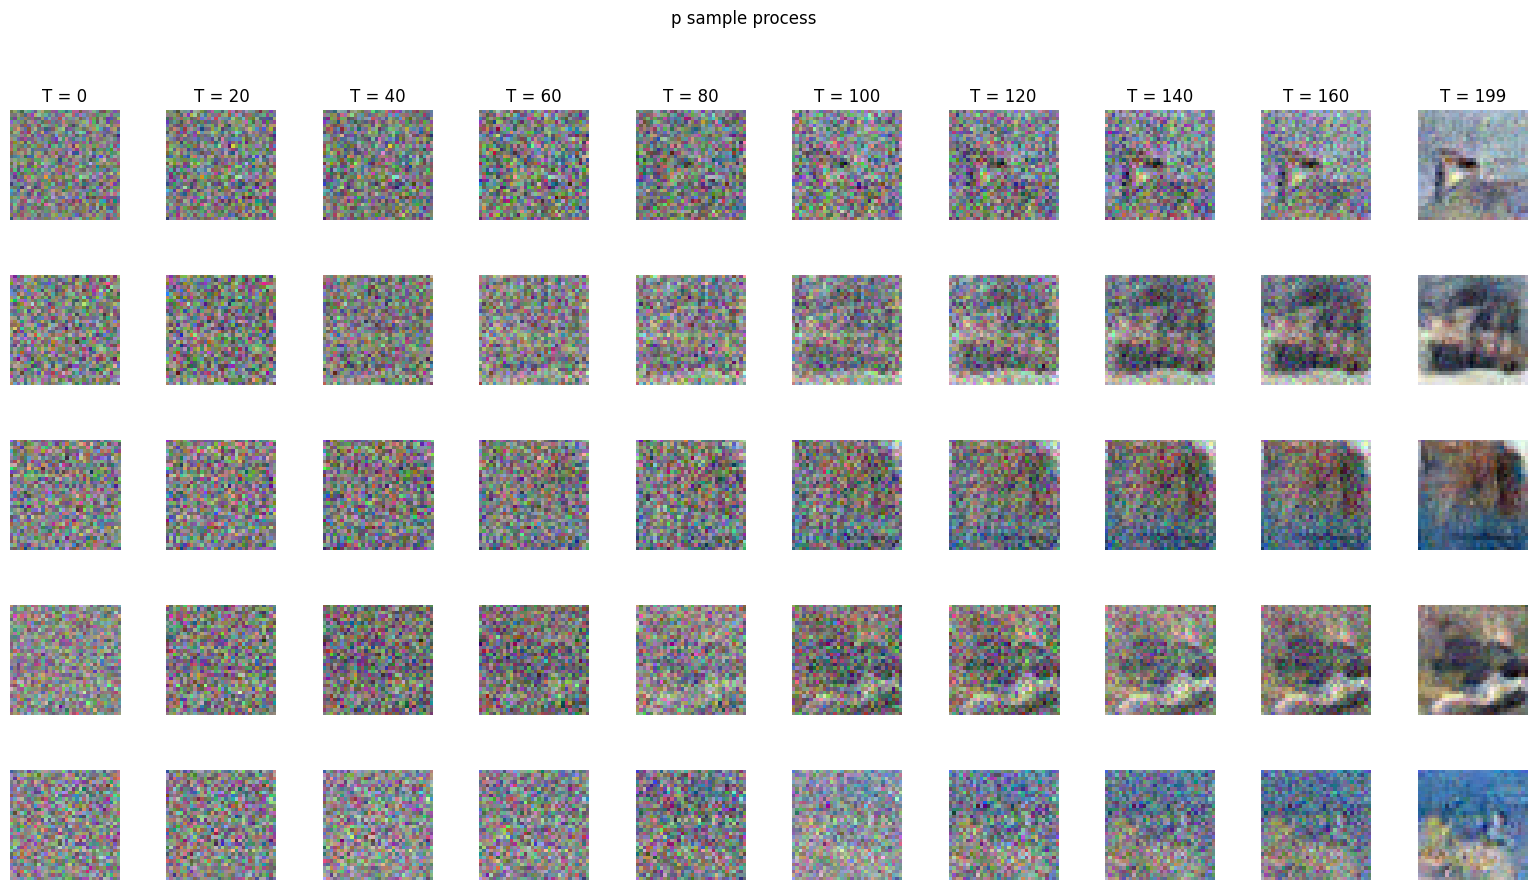

In [95]:
import matplotlib.pyplot as plt
import torch
import random

# 假设你有一个包含图像的张量 image_tensor，形状为 (T, B, C, H, W)
# 替换这里的 image_tensor 为你的实际图像数据

# 获取 timesteps (T)、batch size (B)、通道数 (C)、图像高度 (H) 和图像宽度 (W)
image_tensor = torch.tensor(samples)
T, B, C, H, W = image_tensor.shape

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
batch_index_list = [3, 14, 23, 12, 7]

for i in range(5):

  batch_index = batch_index_list[i]

  for step in range(T):
    if (step % 20 == 0) or (step==199):
      image = image_tensor[step, batch_index].numpy()

      # transformation
      min_value = image.min()
      max_value = image.max()
      new_min = 0
      new_max = 255
      mapped_array = (image - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
      mapped_array = np.round(mapped_array).astype(int)
      mapped_array = np.transpose(mapped_array, (1, 2, 0))

      axes[i, step // 20].imshow(mapped_array)
      axes[i, step // 20].axis("off")
      if i==0:
         axes[i, step // 20].set_title(f'T = {step}')

plt.suptitle('p sample process')
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()


In [102]:
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [103]:
def get_noisy_image(x_start, t):
  # add noise
  # x_start_tensor = torch.tensor(x_start)
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

(-0.5, 31.5, 31.5, -0.5)

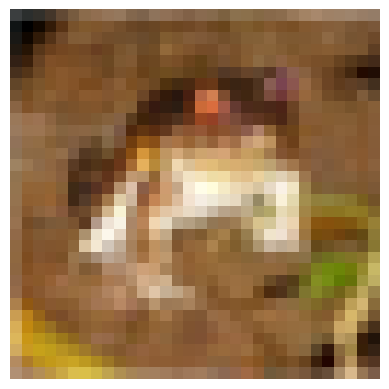

In [91]:
plt.imshow(trainset.data[0])
plt.axis("off")

In [104]:
from torchvision.transforms import ToPILImage

single_image = ToPILImage()(trainset.data[0])

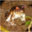

In [ ]:
single_image

In [105]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
])

x_start = transform(single_image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [106]:
import numpy as np
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

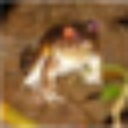

In [ ]:
reverse_transform(x_start.squeeze())

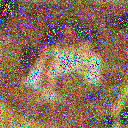

In [107]:
t = torch.tensor([40])

get_noisy_image(x_start, t)

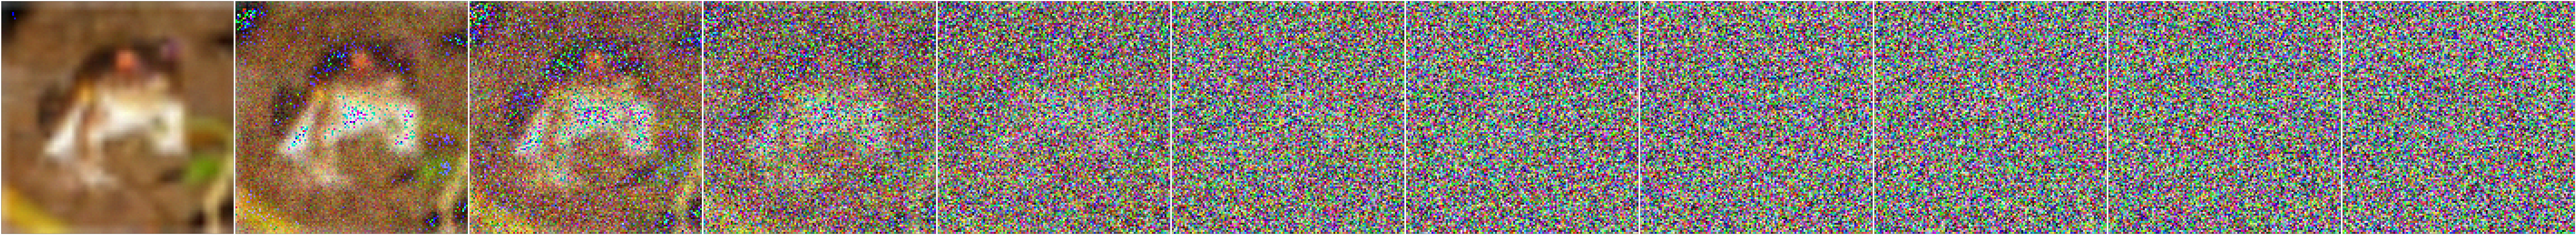

In [116]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 199]])

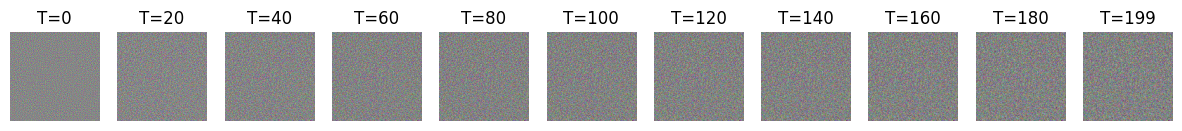

In [117]:
# 怎么print predicted noise


timesteps = 200
batch_size = 1

noise = torch.randn_like(x_start)
# t = torch.randint(0, timesteps, (batch_size,), device=device).long()

fig, axes = plt.subplots(1, 11, figsize=(15, 2))  # 1 row, 10 columns
t_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 199]

for i in range(11):
  # t=torch.tensor([0])
  t = torch.tensor([t_list[i]])
  x_noisy = q_sample(x_start=x_start.to(device), t=t.to(device), noise=noise.to(device))
  predicted_noise = model(x_noisy, t)

  min_value = predicted_noise.min().item()
  max_value = predicted_noise.max().item()
  new_min = 0
  new_max = 255

  # 使用映射公式进行映射
  mapped_array = (predicted_noise.squeeze() - min_value) / (max_value - min_value) * (new_max - new_min) + new_min
  mapped_array = np.round(mapped_array.detach().numpy()).astype(int)
  mapped_array = np.transpose(mapped_array, (1, 2, 0))

  axes[i].imshow(mapped_array)  # cmap='gray' 表示以灰度模式显示图像
  axes[i].set_title("T={}".format(t.item()))
  axes[i].axis('off')  # 关闭坐标轴

AttributeError: ignored

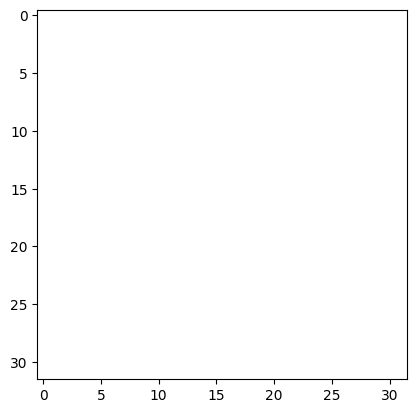

In [ ]:
import matplotlib.animation as animation

random_index = 53
image_size = 32

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

## FID

In [ ]:
!pip install torchmetrics torch-fidelity

In [ ]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
dataset_tensor = torch.tensor(trainset.data)[:100].permute(0,3,1,2)
dataset_tensor_2 = torch.tensor(trainset.data)[101:201].permute(0,3,1,2)

In [ ]:
dataset_tensor.shape, dataset_tensor_2.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100, 3, 32, 32]))

In [ ]:
gen_samples = sample(model, image_size=image_size, batch_size=100, channels=channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
gen_tensor = torch.tensor(gen_samples[199])
pure_noisy_tensor = torch.tensor(gen_samples[0])

In [ ]:
# https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html
_ = torch.manual_seed(123)
fid = FrechetInceptionDistance(feature=64, normalize=True)
# generate two slightly overlapping image intensity distributions
fid.update(dataset_tensor, real=True)
fid.update(gen_tensor, real=False)
fid.compute()

tensor(17.1172)

In [ ]:
# get minimum FID

_ = torch.manual_seed(123)
fid = FrechetInceptionDistance(feature=64, normalize=True)
# generate two slightly overlapping image intensity distributions
fid.update(dataset_tensor, real=True)
fid.update(dataset_tensor_2, real=False)
fid.compute()

tensor(0.2429)

In [ ]:
# get maximum FID

_ = torch.manual_seed(123)
fid = FrechetInceptionDistance(feature=64, normalize=True)
# generate two slightly overlapping image intensity distributions
fid.update(dataset_tensor, real=True)
fid.update(pure_noisy_tensor, real=False)
fid.compute()

tensor(48.1974)

# condition

In [15]:
class UNet_conditional(Unet):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None):
      #要把这里改成dim channels dim mults
        super().__init__(c_in, c_out, time_dim)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)


    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)


        if y is not None:
            t += self.label_emb(y)


        return self.unet_forwad(x, t)

In [29]:
model_2 = UNet_conditional(
    c_in=3,
    c_out=3,
    time_dim=200,
    num_classes=10
)

model_2.to(device)

UNet_conditional(
  (init_conv): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=3, out_features=12, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=12, out_features=12, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ConvNextBlock(
        (mlp): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=12, out_features=3, bias=True)
        )
        (ds_conv): Conv2d(3, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=3)
        (net): Sequential(
          (0): GroupNorm(1, 3, eps=1e-05, affine=True)
          (1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 6, eps=1e-05, affine=True)
          (4): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Iden

In [30]:
params = list(model_2.parameters())

total_params = sum(p.numel() for p in params)

total_params

186970

In [32]:
!pip install torch-summary
from torchsummary import summary
summary(model_2, input_size=(3, 32, 32))

Layer (type:depth-idx)                        Param #
├─Conv2d: 1-1                                 444
├─Sequential: 1-2                             --
|    └─SinusoidalPositionEmbeddings: 2-1      --
|    └─Linear: 2-2                            48
|    └─GELU: 2-3                              --
|    └─Linear: 2-4                            156
├─ModuleList: 1-3                             --
|    └─ModuleList: 2-5                        --
|    |    └─ConvNextBlock: 3-1                540
|    |    └─ConvNextBlock: 3-2                540
|    |    └─Residual: 3-3                     1,551
|    |    └─Conv2d: 3-4                       147
|    └─ModuleList: 2-6                        --
|    |    └─ConvNextBlock: 3-5                1,233
|    |    └─ConvNextBlock: 3-6                1,728
|    |    └─Residual: 3-7                     3,102
|    |    └─Conv2d: 3-8                       582
|    └─ModuleList: 2-7                        --
|    |    └─ConvNextBlock: 3-9                

Layer (type:depth-idx)                        Param #
├─Conv2d: 1-1                                 444
├─Sequential: 1-2                             --
|    └─SinusoidalPositionEmbeddings: 2-1      --
|    └─Linear: 2-2                            48
|    └─GELU: 2-3                              --
|    └─Linear: 2-4                            156
├─ModuleList: 1-3                             --
|    └─ModuleList: 2-5                        --
|    |    └─ConvNextBlock: 3-1                540
|    |    └─ConvNextBlock: 3-2                540
|    |    └─Residual: 3-3                     1,551
|    |    └─Conv2d: 3-4                       147
|    └─ModuleList: 2-6                        --
|    |    └─ConvNextBlock: 3-5                1,233
|    |    └─ConvNextBlock: 3-6                1,728
|    |    └─Residual: 3-7                     3,102
|    |    └─Conv2d: 3-8                       582
|    └─ModuleList: 2-7                        --
|    |    └─ConvNextBlock: 3-9                

In [33]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0


    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)


    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new


    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1


    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


In [34]:
def train_step(self):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()


def one_epoch(self, train=True, use_wandb=False):
    avg_loss = 0.
    if train: self.model.train()
    else: self.model.eval()
    pbar = progress_bar(self.train_dataloader, leave=False)
    for i, (images, labels) in enumerate(pbar):
        with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
            images = images.to(self.device)
            labels = labels.to(self.device)
            t = self.sample_timesteps(images.shape[0]).to(self.device)
            x_t, noise = self.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = self.model(x_t, t, labels)
            loss = self.mse(noise, predicted_noise)
            avg_loss += loss
        if train:
            self.train_step()
            if use_wandb:
                wandb.log({"train_mse": loss.item(),
                            "learning_rate": self.scheduler.get_last_lr()[0]})
        pbar.comment = f"MSE={loss.item():2.3f}"
    return avg_loss.mean().item()


In [36]:
@torch.inference_mode()
def log_images(self):
    "Log images to wandb and save them to disk"
    labels = torch.arange(self.num_classes).long().to(self.device)
    sampled_images = self.sample(use_ema=False, n=len(labels), labels=labels)
    ema_sampled_images = self.sample(use_ema=True, n=len(labels), labels=labels)
    plot_images(sampled_images)  #to display on jupyter if available
    # log images to wandb
    wandb.log({"sampled_images":     [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in sampled_images]})
    wandb.log({"ema_sampled_images": [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in ema_sampled_images]})

In [37]:
def save_model(self, run_name, epoch=-1):
    "Save model locally and to wandb"
    torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
    torch.save(self.ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
    torch.save(self.optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))
    at = wandb.Artifact("model", type="model", description="Model weights for DDPM conditional", metadata={"epoch": epoch})
    at.add_dir(os.path.join("models", run_name))
    wandb.log_artifact(at)


In [38]:
def prepare(self, args):
    "Prepare the model for training"
    setup_logging(args.run_name)
    device = args.device
    self.train_dataloader, self.val_dataloader = get_data(args)
    self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, weight_decay=0.001)
    self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr,
                                                steps_per_epoch=len(self.train_dataloader), epochs=args.epochs)
    self.mse = nn.MSELoss()
    self.ema = EMA(0.995)
    self.scaler = torch.cuda.amp.GradScaler()


def fit(self, args):
    self.prepare(args)
    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        self.one_epoch(train=True)

        ## validation
        if args.do_validation:
            self.one_epoch(train=False)

        # log predicitons
        if epoch % args.log_every_epoch == 0:
            self.log_images(use_wandb=args.use_wandb)


    # save model
    self.save_model(run_name=args.run_name, use_wandb=args.use_wandb, epoch=epoch)
